In [63]:
from langgraph.graph import StateGraph, START, END
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import TypedDict, Literal, Dict
from langchain_core.prompts import PromptTemplate
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
import pdfplumber
import json
import os 

In [64]:
#Loading .env file
load_dotenv()

True

In [65]:
# Groq related Global variables
groq_api_key=os.getenv("Groq_API_Key")
groq_temperature=os.getenv("Groq_Temperature")
groq_model_name=os.getenv("Groq_Model_Name")

# Ollama related Global variables
ollama_embedding_model_name=os.getenv("Ollama_Embedding_Model_Name")
ollama_model_temperature=os.getenv("Ollama_Embedding_Model_Temperature")

# printing the values
# print("Groq api keys : ",groq_api_key)
# print("Groq temperature : ",groq_temperature)
# print("Groq_model_name : ",groq_model_name)

# print("Ollama model name : ",ollama_embedding_model_name)
# print("Ollama model temperature : ",ollama_model_temperature)

In [66]:
# Pydantic Class
class LLM_Structured_Output(BaseModel):
    answer:str=Field("This key contain the answer provided by the llm based on the provided context.")
    confidence:int=Field("This key contain how much confidence llm have on the provided output.")
    risk_level:Literal["Low","Medium","High"]=Field("This key contain the risk in the provided answer for taking decision.")
    decision:Literal["Show answer","Show Warning","Block Answer","Ask user to rephrase."]=Field("This key is for the decision of the LLM for showing, warning, blocking and rephrasing the the answer.")
    warning_message:str=Field("This key contain the warning given by the model if there is not any warnong then put 'None' in it.")

In [67]:
# creating the state 
class ai_monitoring_state(TypedDict):
    query:str
    context:str
    PDFFile_path:str

    texual_loaded_data:str
    tabular_loaded_data:str
    image_loaded_data:str
    texual_splitted_data:str
    tabular_splitted_data:str
    image_splitted_data:str
    ollama_embedding_model:any
    texual_vs:any
    tabular_vs:any
    texual_retriever_context:str
    tabular_retriever_context:str

    tabular_to_text_converted_data:str

    main_prompt:str

    llm_answer:Dict
    sources:str

In [68]:
parser = PydanticOutputParser(
    pydantic_object=LLM_Structured_Output
)

print("This is parser : ",parser)

This is parser :  pydantic_object=<class '__main__.LLM_Structured_Output'>


In [69]:
# LLM model getting here 
model=ChatGroq(model=groq_model_name,temperature=groq_temperature)
print("This is model : ",model)

This is model :  profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True} client=<groq.resources.chat.completions.Completions object at 0x000002B43CCF4E50> async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002B43CBEF910> model_name='openai/gpt-oss-120b' temperature=0.4 model_kwargs={} groq_api_key=SecretStr('**********')


In [70]:
query="What are the seven wonders in the india?"
prompt = PromptTemplate(
    template="""
        You must answer ONLY in valid JSON.
        Do not add explanation or text outside JSON.

        {format_instructions}

        Question:
        {query}
    """,
    input_variables=["query"],
    partial_variables={
        "format_instructions": parser.get_format_instructions()
    }
)


In [71]:
chain=prompt|model|parser

In [72]:
output=chain.invoke({"query":query})

In [73]:
print(output.answer)
print(output.confidence)
print(output.risk_level)
print(output.decision)
print(output.warning_message)

The commonly cited Seven Wonders of India are:
1. Taj Mahal
2. Qutub Minar
3. Red Fort
4. Hampi
5. Khajuraho Temples
6. Konark Sun Temple
7. Mysore Palace
9
Low
Show answer
None


In [74]:
# Creating the Document Loader node
def Texual_Data_Loader(state:ai_monitoring_state):
    texual_loader=PyPDFLoader(file_path=state["PDFFile_path"])
    texual_loaded_data=texual_loader.load()
    return {"texual_loaded_data":texual_loaded_data}

def Tabular_Data_Loader(state:ai_monitoring_state):
    tables = []
    with pdfplumber.open(state["PDFFile_path"]) as pdf:
        if pdf.pages:
            for page in pdf.pages:
                for table in page.extract_tables():
                    tables.append({"columns":table[0],"rows":table[1:]})
    return {"tabular_loaded_data":tables}

In [75]:
# node for the tabular data to the texual format creation
def Tabular_to_text_conversion(state:ai_monitoring_state):
    prompt=PromptTemplate(template="""
        You are an expert assistant specialized in transforming extracted tabular data into clean, readable natural language.
        You will receive content that originally comes from a table, but it may appear flattened, noisy, incomplete, or poorly structured.

        Your task is to:

            1. Identify the table structure by recognizing the **column headers** (under the "columns" key) and the corresponding **row values** (under the "rows" key), even if formatting is imperfect.
            2. Preserve all semantic relationships between columns and rows accurately.
            3. Convert each row into a complete, clear, and grammatically correct sentence using the column context.
            4. Ensure that no information from the original table is lost or ignored.
            5. Do NOT hallucinate, guess missing values, or introduce any new information that is not present in the data.
            6. Produce the final output as a coherent textual explanation suitable for documentation, retrieval, and downstream RAG applications.

        Tabular Data Input:
        {tabular_data}

        Return only the converted textual representation.
    """,input_variables=['tabular_data'])

    llm = ChatGroq(model=groq_model_name,temperature=groq_temperature)
    parser = StrOutputParser()
    
    chain = prompt | llm | parser
    data=chain.invoke({
        "tabular_data": state["tabular_loaded_data"]
    })
    return {'tabular_to_text_converted_data':data}

In [76]:
# Creating the text splitter node
def Textual_Data_Splitter(state: ai_monitoring_state):
    textual_data = state["texual_loaded_data"]
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    texts = splitter.split_documents(textual_data)
    return {"texual_splitted_data": texts}

def Tabular_Data_Splitter(state:ai_monitoring_state):
    tabular_to_text_data = state["tabular_to_text_converted_data"]
    docs = [
        Document(page_content=json.dumps(table))
        for table in tabular_to_text_data
    ]
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    texts = splitter.split_documents(docs)
    return {"tabular_splitted_data": texts}

In [77]:
# Node for Embedding of the texual document
def Data_Embedding(state: ai_monitoring_state):
    emb=OllamaEmbeddings(model=ollama_embedding_model_name)
    return {"ollama_embedding_model":emb}

In [78]:
# Node for texual data in the vectorstoring 
def Texual_VectorStore(state: ai_monitoring_state):
    tvs=FAISS.from_documents(state['texual_splitted_data'],state['ollama_embedding_model'])
    return {'texual_vs':tvs}

def Tabular_VectorStore(state: ai_monitoring_state):
    tvs=FAISS.from_documents(state['tabular_splitted_data'],state['ollama_embedding_model'])
    return {'tabular_vs':tvs}

In [79]:
# node for the texual data retriever
def Texual_VectorStoreRetriever(state:ai_monitoring_state):
    vs=state["texual_vs"]
    retriever=vs.as_retriever(search_type="mmr", search_kwargs={"k": 6, "lambda_mult": 0.1})
    out=retriever.invoke(state['query'])
    return {'texual_retriever_context':out}

def Tabular_VectorStoreRetriever(state:ai_monitoring_state):
    vs=state["tabular_vs"]
    retriever=vs.as_retriever(search_type="mmr", search_kwargs={"k": 6, "lambda_mult": 0.1})
    out=retriever.invoke(state['query'])
    return {'tabular_retriever_context':out}

In [80]:
# Node the llm answer generation
def LLM_model_call(state:ai_monitoring_state):
    
    texual_context_data="".join([i.page_content for i in state['texual_retriever_context']])
    tabular_context_data="".join([i.page_content for i in state['tabular_retriever_context']])

    state['main_prompt']=PromptTemplate(
        template="""
            You are the excellent output generator.
            your main work is provide the clean, polished, professional and in day to day enlgish of the user query based on the provided context.
            below is the user query and context:
            user query : {query}
            Texual context data : {texual}
            Tabular context data : {tabular}

            {format_instructions}
        """,
        input_variables=['query','texual','tabular'],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain=state['main_prompt']|model|parser

    output=chain.invoke({
        'query':state['query'],
        'texual':texual_context_data,
        'tabular':tabular_context_data
    })

    return {"llm_answer":output}    

In [81]:
graph=StateGraph(ai_monitoring_state)

In [82]:
graph.add_node("Texual_Data_Loader",Texual_Data_Loader)
graph.add_node("Textual_Data_Splitter",Textual_Data_Splitter)
graph.add_node("Data_Embedding",Data_Embedding)
graph.add_node("Texual_VectorStore",Texual_VectorStore)
graph.add_node("Texual_VectorStoreRetriever",Texual_VectorStoreRetriever)
graph.add_node('LLM_model_call',LLM_model_call)

graph.add_node('Tabular_Data_Loader',Tabular_Data_Loader)
graph.add_node('Tabular_to_text_conversion',Tabular_to_text_conversion)
graph.add_node('Tabular_Data_Splitter',Tabular_Data_Splitter)
graph.add_node('Tabular_VectorStore',Tabular_VectorStore)
graph.add_node('Tabular_VectorStoreRetriever',Tabular_VectorStoreRetriever)

In [83]:
graph.add_edge(START,"Texual_Data_Loader")
graph.add_edge("Texual_Data_Loader","Textual_Data_Splitter")
graph.add_edge("Textual_Data_Splitter","Data_Embedding")
graph.add_edge("Data_Embedding","Texual_VectorStore")
graph.add_edge("Texual_VectorStore","Texual_VectorStoreRetriever")
graph.add_edge("Texual_VectorStoreRetriever",'LLM_model_call')
graph.add_edge('LLM_model_call',END)

graph.add_edge(START,"Tabular_Data_Loader")
graph.add_edge('Tabular_Data_Loader','Tabular_to_text_conversion')
graph.add_edge("Tabular_to_text_conversion",'Tabular_Data_Splitter')
graph.add_edge("Tabular_Data_Splitter","Data_Embedding")
graph.add_edge('Data_Embedding','Tabular_VectorStore')
graph.add_edge('Tabular_VectorStore','Tabular_VectorStoreRetriever')
graph.add_edge('Tabular_VectorStoreRetriever','LLM_model_call')

In [84]:
workflow=graph.compile()

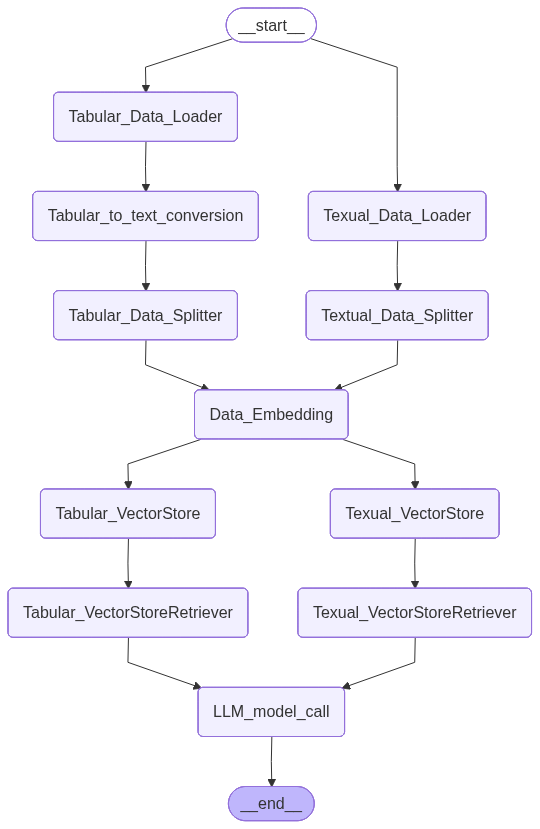

In [85]:
workflow

In [86]:
output=workflow.invoke(
    {
        "PDFFile_path":"../Input-Document/bh1.pdf",
        "query":"What is summery of the document?"
    }
)

In [94]:
print(output['llm_answer'].answer)

The document outlines India’s 2025‑2026 budget, emphasizing inclusive, secure development aimed at a "Viksit Bharat" (developed India). Key themes include boosting agriculture, MSMEs, investment, and exports as growth engines, supported by reforms and a focus on the rising middle class. Major initiatives cover:
- Enhanced social welfare (day‑care cancer centres, PM SVANidhi revamp, e‑Shram registration for platform workers, health coverage under PM Jan Arogya Yojana).
- Tax reforms targeting the middle class: higher deduction limits for senior citizens, increased TDS thresholds, extended filing windows, and simplified compliance for charitable trusts.
- Incentives for manufacturing and tourism, including e‑visa facilitation and development of top tourist sites.
- Agricultural and rural development programs such as the National Mission on High‑Yielding Seeds, Prime Minister Dhan‑Dhaanya Krishi Yojana, cotton productivity missions, and credit schemes for farmers, fishermen, and dairy pro

In [88]:
output['query']

'What is summery of the document?'

In [89]:
for i in output['texual_retriever_context']:
    print(i.page_content)

Journey of Development
A country is not just its soil, a country is its people.
Agriculture
MSME
Investment
Exports 
Engines of development
The fuel: Reforms
Guiding spirit: Inclusivity
Destination: Viksit Bharat
Secure Inclusive Development
Enhance Spending Power Of India’s Rising 
Middle Class
Invigorate Private Sector Investments
Uplift Household Sentiments
Accelerate Growth
Aspiration for  
Viksit Bharat
Page 1
Key Features 
of
Budget
2025-2026
February, 2025
ºÉiªÉàÉä´É VÉªÉiÉä
Day Care Cancer Centres in all District Hospitals  
PM SV ANidhi: To be revamped with enhanced loans from
banks, UPI linked credit cards and capacity building support.
Welfare of Online Platform Workers: Registration on the
e-Shram portal & healthcare under PM Jan Arogya Yojana.
Page 4
Reduced compliance for small charitable trusts/institutions
by increasing their period of registration from 5 years to 10
years.
Tax payers to be allowed to claim the annual value of 02 self
occupied properties (previously 01)

In [93]:
output['tabular_loaded_data']

[{'columns': ['', ''], 'rows': []},
 {'columns': ['Journey of Development'],
  'rows': [['The fuel: Reforms\nAgriculture\ntnempoleved\nMSME\nGuiding spirit: Inclusivity\nfo\nInvestment\nsenignE\nDestination: Viksit Bharat\nExports'],
   ['A country is not just its soil, a country is its people.'],
   ['Accelerate Growth\nrof\ntarahB\nSecure Inclusive Development\nnoitaripsA\nEnhance Spending Power Of India’s Rising\nMiddle Class tiskiV\nInvigorate Private Sector Investments\nUplift Household Sentiments']]},
 {'columns': [''],
  'rows': [['ro\nta'], ['f rahB\nnoitarips\ntiski'], ['A V'], ['']]},
 {'columns': ['Accelerate Growth', None, None, None],
  'rows': [['Secure Inclusive Development', '', None, None],
   ['Enhance Spending Power Of India’s Rising\nMiddle Class',
    None,
    None,
    None],
   [None, None, '', ''],
   ['Invigorate Private Sector Investments', None, None, None],
   ['Uplift Household Sentiments', None, None, None]]},
 {'columns': [''], 'rows': [['']]},
 {'column

In [91]:
print(output["tabular_to_text_converted_data"])

**Journey of Development**  
The development journey is powered by reforms in agriculture and the MSME sector, guided by an inclusive spirit, bolstered by investment, and aimed at a “Viksit Bharat” with stronger exports. A country is not just its soil; it is its people. The plan seeks to accelerate growth, secure inclusive development, enhance the spending power of India’s rising middle class, invigorate private‑sector investment and uplift household sentiment.  

**Key Objectives (Accelerate Growth)**  
- Secure inclusive development.  
- Enhance the spending power of India’s rising middle class.  
- Invigorate private‑sector investments.  
- Uplift household sentiment.  

**Agricultural and Rural Prosperity Measures (Garib, Youth, Annadata, Nari)**  
- **Spurring agricultural growth & building rural prosperity:** The Prime Minister Dhan‑Dhaanya Krishi Yojana and the “Developing Agri Districts” programme will cover 100 districts, benefitting roughly 1.7 crore farmers.  
- **Cotton pro